In [1]:
import os, sys
sys.path.append("common/")
from python_tools import *

In [2]:
p_tree = uproot.open("/Users/wketchum/MicroBooNE_Data/genie_studies/genie_uboone_100k_simple.root")['particle_tree']
t_tree = uproot.open("/Users/wketchum/MicroBooNE_Data/genie_studies/genie_uboone_100k_simple.root")['mctruth_tree']

p_df = p_tree.pandas.df()
t_df = t_tree.pandas.df()

In [3]:
p_df_grouped = p_df.query("status==1 or (status==0 and pdgcode==14)").groupby(["run","event","truth_index"],as_index=False)

In [4]:
@numba.jit(nopython=True)
def filter_1muNp(energy,mass,status,pdgcode,
                 thresh_mu=0.03,thresh_p=0.03,min_p_count=0,max_p_count=9999):

    ke = energy - mass
    
    mu_count = ((status==1)&(pdgcode==13)&(ke>=thresh_mu)).sum()
    if mu_count==0: return False
    
    pi_count = ((status==1)&((pdgcode==211)^(pdgcode==-211)^(pdgcode==111))).sum()
    if pi_count!=0: return False
    
    p_count = ((status==1)&(pdgcode==2212)&(ke>=thresh_p)).sum()
    if p_count<min_p_count or p_count>max_p_count: return False

    return True
    
def filter_1muNp_numba(p_df,**kwargs):
    return filter_1muNp(p_df["e"].values,p_df["mass"].values,p_df["status"].values,p_df["pdgcode"].values,**kwargs)

In [5]:
@numba.jit
def costheta(p1x,p1y,p1z,p1mag,
             p2x,p2y,p2z,p2mag):
    return np.clip(np.where((p1mag>0.0)&(p2mag>0.0),
                            (p1x*p2x+p1y*p2y+p1z*p2z)/p1mag/p2mag,
                            0.0),
                   -1.0,1.0)

@numba.jit
def q3(p1x,p1y,p1z,p2x,p2y,p2z):
    return np.sqrt((p1x-p2x)**2+(p1y-p2y)**2+(p1z-p2z)**2)

%%time
count=1e6
for (_,_,_),group in p_df_grouped:
    #print group
    #print "\n\n"
    filter_1muNp_numba(group,thresh_mu=0.0,thresh_p=0.03,min_p_count=1,max_p_count=1)
    count = count-1
    if count==0: break

In [6]:
p_df_1mu1p = p_df_grouped.filter(lambda x: filter_1muNp_numba(x,thresh_mu=0.0,thresh_p=0.03,min_p_count=1,max_p_count=1))
p_df_1mu1p_p1 = p_df_1mu1p.query("pdgcode==2212").sort_values(by=["e"],ascending=False).groupby(["run","event","truth_index"],as_index=False).nth(0).sort_values(by=["event"])
p_df_1mu1p_mu = p_df_1mu1p.query("pdgcode==13").groupby(["run","event","truth_index"],as_index=False).first()
p_df_1mu1p_nu = p_df_1mu1p.query("pdgcode==14").groupby(["run","event","truth_index"],as_index=False).first()

In [7]:
df_1mu1p = t_df.copy()
df_1mu1p = df_1mu1p.merge(p_df_1mu1p_nu,on=["run","event","truth_index"],suffixes=["","_nu"])
df_1mu1p = df_1mu1p.merge(p_df_1mu1p_mu,on=["run","event","truth_index"],suffixes=["","_mu"])
df_1mu1p = df_1mu1p.merge(p_df_1mu1p_p1,on=["run","event","truth_index"],suffixes=["","_p1"])

In [8]:
df_1mu1p["costheta_mu"] = costheta(df_1mu1p["px"].values,df_1mu1p["py"].values,df_1mu1p["pz"].values,
                                   df_1mu1p["p"].values,
                                   df_1mu1p["px_mu"].values,df_1mu1p["py_mu"].values,df_1mu1p["pz_mu"].values,
                                   df_1mu1p["p_mu"].values)
df_1mu1p["costheta_p1"] = costheta(df_1mu1p["px"].values,df_1mu1p["py"].values,df_1mu1p["pz"].values,
                                   df_1mu1p["p"].values,
                                   df_1mu1p["px_p1"].values,df_1mu1p["py_p1"].values,df_1mu1p["pz_p1"].values,
                                   df_1mu1p["p_p1"].values)

df_1mu1p["q0"] = df_1mu1p["e"] - df_1mu1p["e_mu"]
df_1mu1p["q3"] = q3(df_1mu1p["px"].values,df_1mu1p["py"].values,df_1mu1p["pz"].values,
                    df_1mu1p["px_mu"].values,df_1mu1p["py_mu"].values,df_1mu1p["pz_mu"].values)

<IPython.core.display.Javascript object>


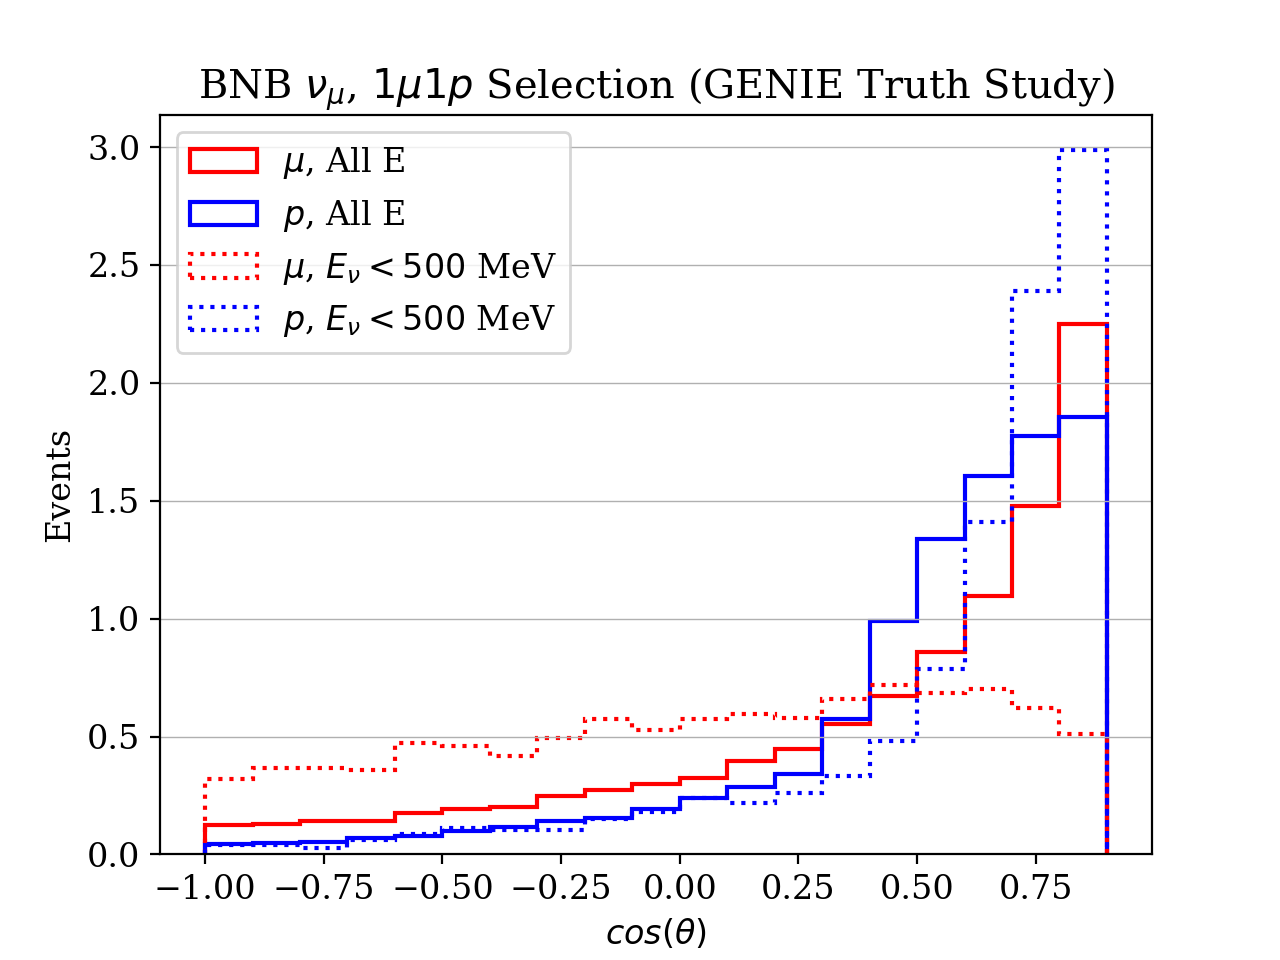

In [9]:
%matplotlib notebook

bins_theta = np.arange(-1.0,1.0,0.1)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1mu1p["costheta_mu"], color='red', label='$\mu$, All E', bins=bins_theta, density=True,**pltops_hist)
plt.hist(df_1mu1p["costheta_p1"], color='blue', label='$p$, All E', bins=bins_theta, density=True,**pltops_hist)
plt.hist(df_1mu1p.query("e<0.5")["costheta_mu"], color='red', label='$\mu$, $E_\\nu<500$ MeV', linestyle=":", bins=bins_theta, density=True,**pltops_hist)
plt.hist(df_1mu1p.query("e<0.5")["costheta_p1"], color='blue', label='$p$, $E_\\nu<500$ MeV', linestyle=":", bins=bins_theta, density=True,**pltops_hist)
plt.legend(loc=2)
plt.title("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
plt.xlabel("$cos(\\theta)$")
plt.ylabel("Events")
plt.show()
#plt.savefig("genie_1mu1p_costheta.pdf")

<IPython.core.display.Javascript object>


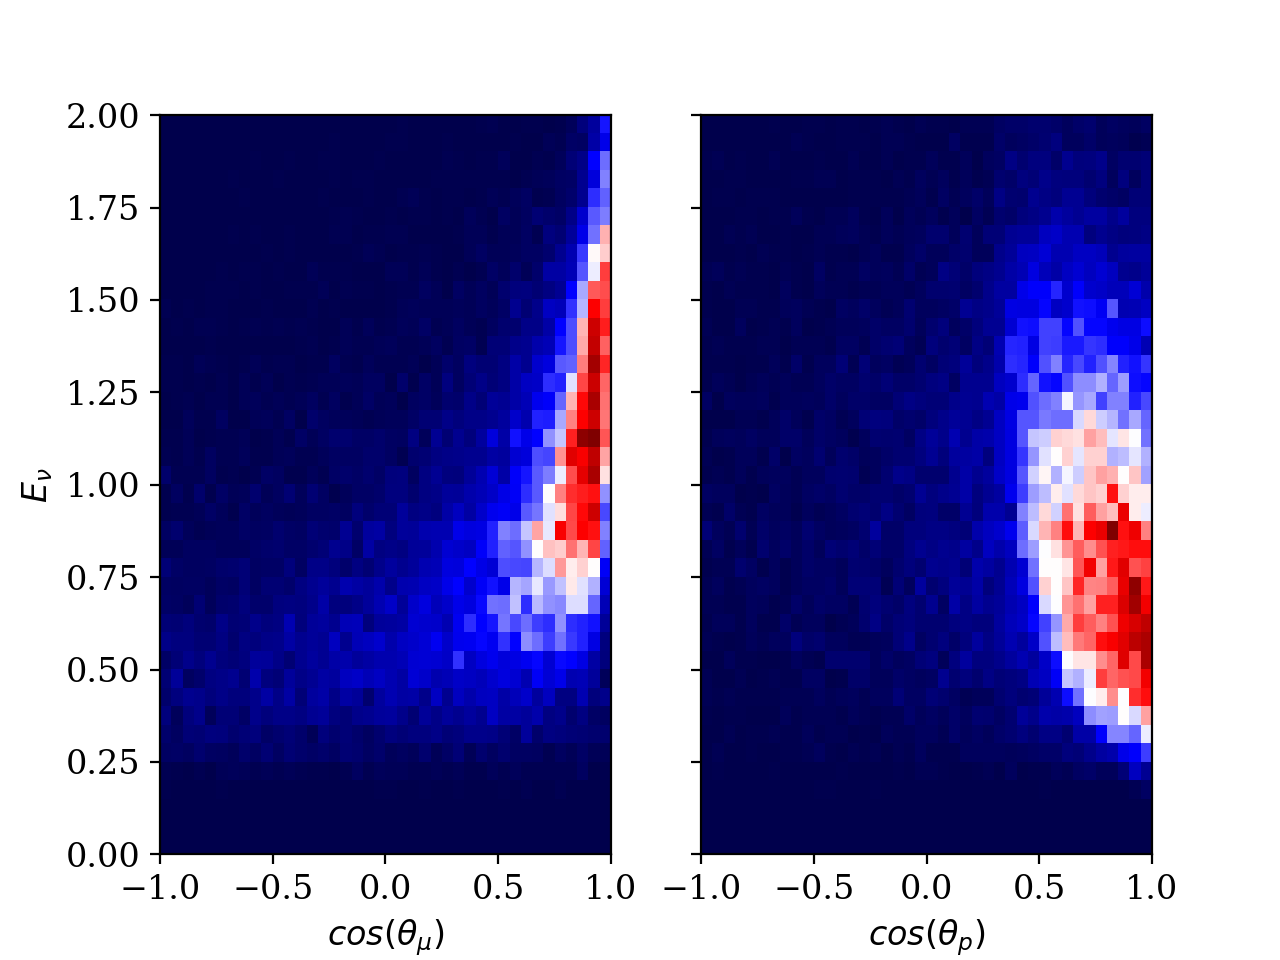

In [10]:
fig,axes = plt.subplots(1,2,sharex='all', sharey='all')

axes[0].hist2d(df_1mu1p["costheta_mu"],df_1mu1p["e"],bins=[40,40],range=[[-1,1],[0,2]])
axes[1].hist2d(df_1mu1p["costheta_p1"],df_1mu1p["e"],bins=[40,40],range=[[-1,1],[0,2]])
#axes[0].title("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
axes[0].set_xlabel("$cos(\\theta_\mu)$")
axes[1].set_xlabel("$cos(\\theta_p)$")
axes[0].set_ylabel("$E_\\nu$")
plt.show()


<IPython.core.display.Javascript object>


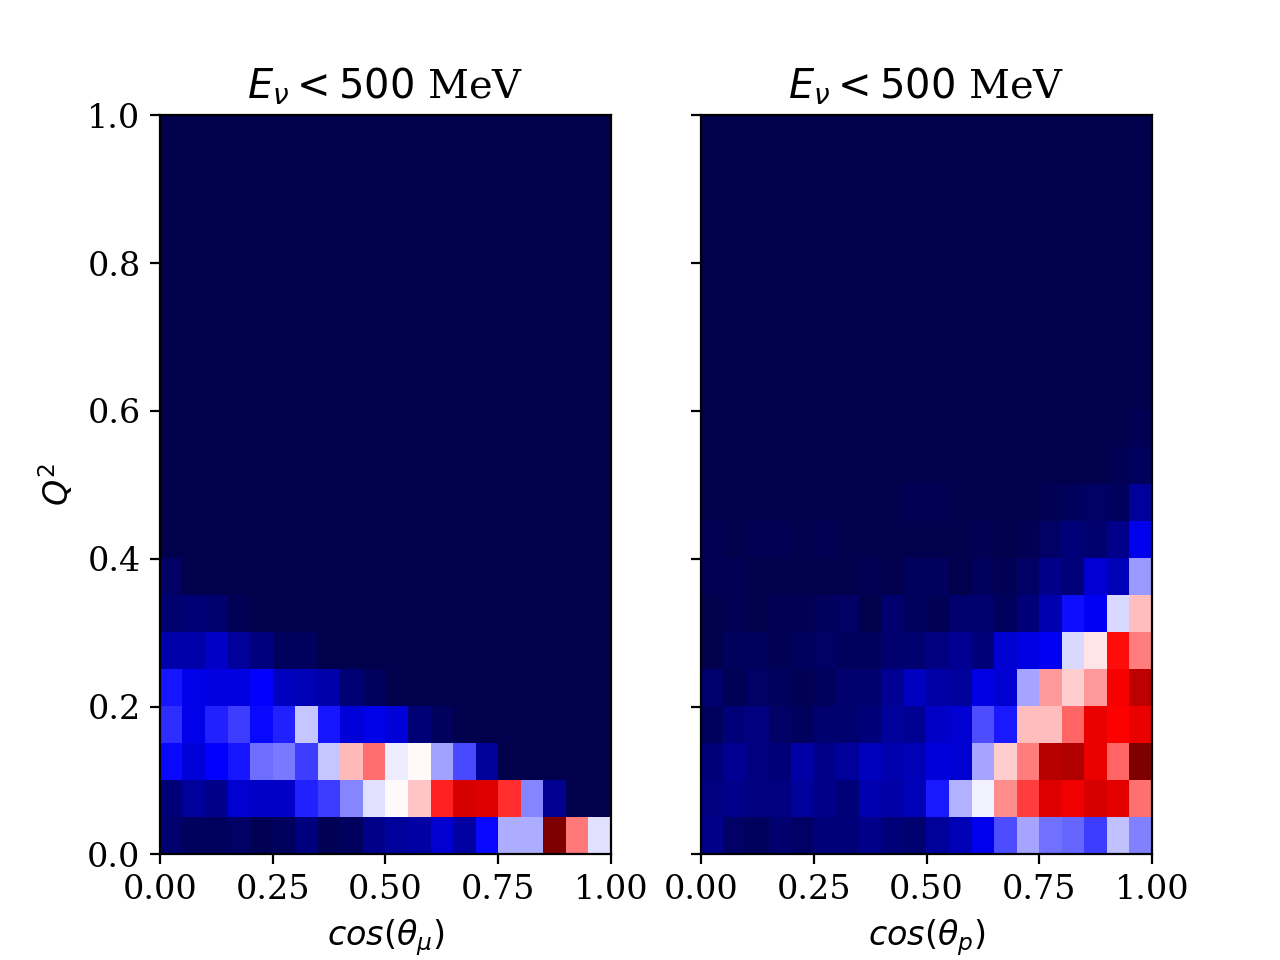

In [23]:
fig,axes = plt.subplots(1,2,sharex='all', sharey='all')

axes[0].hist2d(df_1mu1p.query("e<0.5")["costheta_mu"],df_1mu1p.query("e<0.5")["interaction_q2"],bins=[20,20],range=[[0,1],[0,1]])
axes[1].hist2d(df_1mu1p.query("e<0.5")["costheta_p1"],df_1mu1p.query("e<0.5")["interaction_q2"],bins=[20,20],range=[[0,1],[0,1]])
#axes[0].title("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
axes[0].set_xlabel("$cos(\\theta_\mu)$")
axes[1].set_xlabel("$cos(\\theta_p)$")
axes[0].set_ylabel("$Q^2$")
axes[0].set_title("$E_\\nu < 500$ MeV")
axes[1].set_title("$E_\\nu < 500$ MeV")
plt.show()


<IPython.core.display.Javascript object>


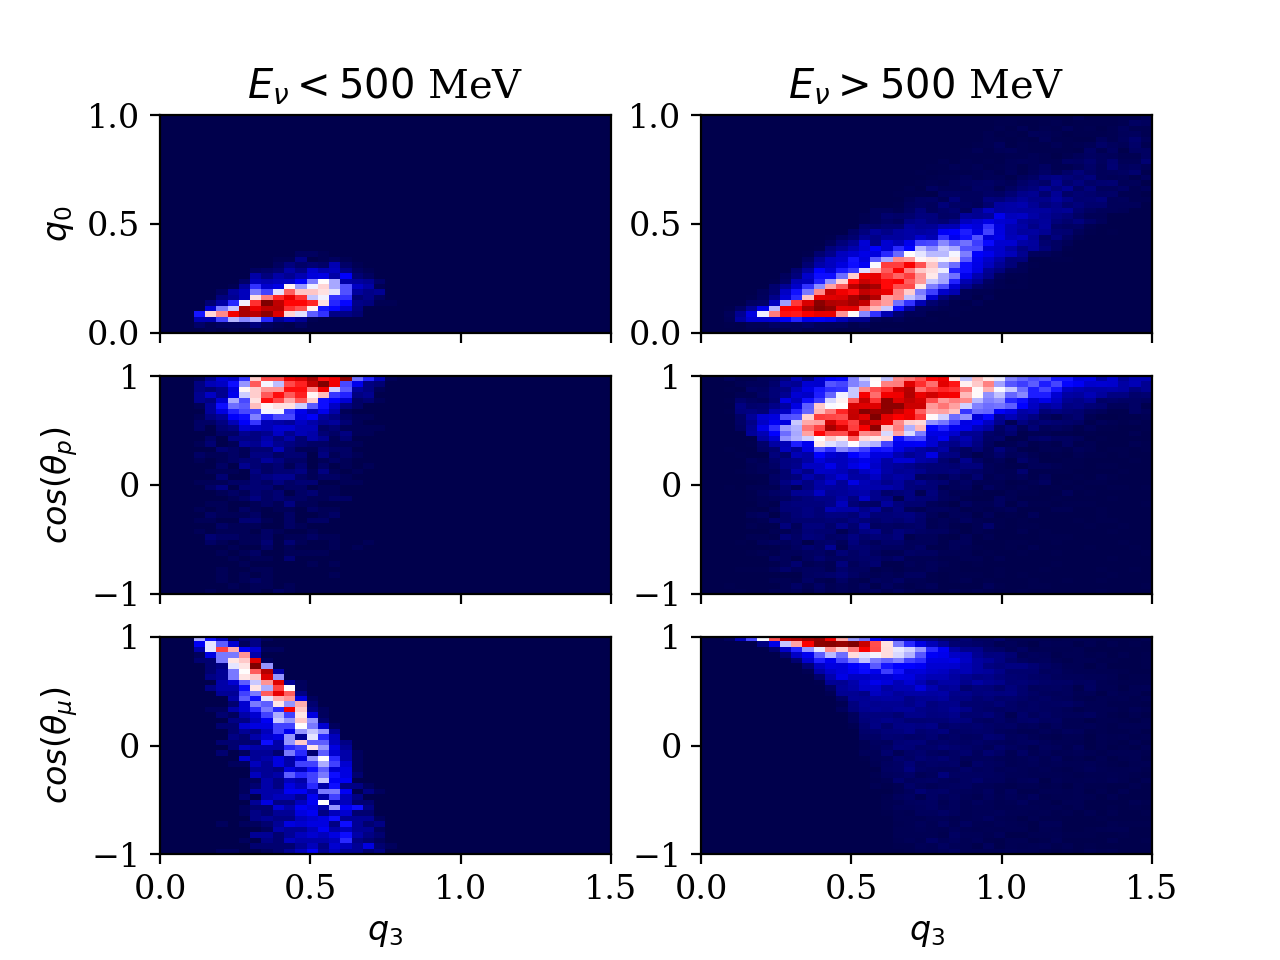

In [12]:
fig,axes = plt.subplots(3,2,sharex='all')

axes[0,0].hist2d(df_1mu1p.query("e<0.5")["q3"],df_1mu1p.query("e<0.5")["q0"],bins=[40,40],range=[[0,1.5],[0,1.0]])
axes[0,1].hist2d(df_1mu1p.query("e>0.5")["q3"],df_1mu1p.query("e>0.5")["q0"],bins=[40,40],range=[[0,1.5],[0,1.0]])
axes[1,0].hist2d(df_1mu1p.query("e<0.5")["q3"],df_1mu1p.query("e<0.5")["costheta_p1"],bins=[40,40],range=[[0,1.5],[-1.0,1.0]])
axes[1,1].hist2d(df_1mu1p.query("e>0.5")["q3"],df_1mu1p.query("e>0.5")["costheta_p1"],bins=[40,40],range=[[0,1.5],[-1.0,1.0]])
axes[2,0].hist2d(df_1mu1p.query("e<0.5")["q3"],df_1mu1p.query("e<0.5")["costheta_mu"],bins=[40,40],range=[[0,1.5],[-1.0,1.0]])
axes[2,1].hist2d(df_1mu1p.query("e>0.5")["q3"],df_1mu1p.query("e>0.5")["costheta_mu"],bins=[40,40],range=[[0,1.5],[-1.0,1.0]])
#axes[0].title("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
axes[2,0].set_xlabel("$q_3$")
axes[2,1].set_xlabel("$q_3$")
axes[0,0].set_ylabel("$q_0$")
axes[1,0].set_ylabel("$cos(\\theta_p)$")
axes[2,0].set_ylabel("$cos(\\theta_\mu)$")
axes[0,0].set_title("$E_\\nu < 500$ MeV")
axes[0,1].set_title("$E_\\nu > 500$ MeV")
plt.show()


<IPython.core.display.Javascript object>


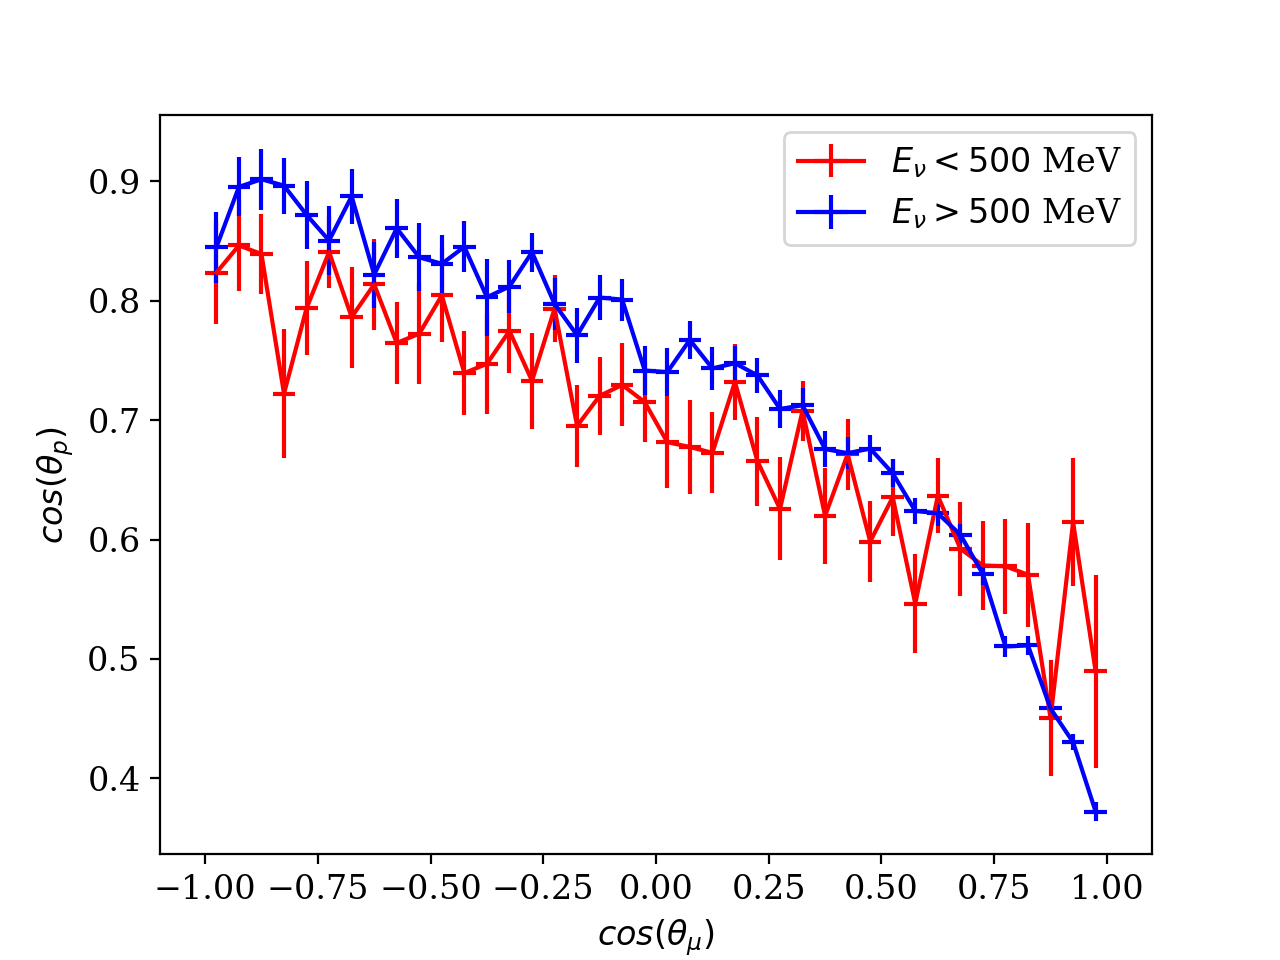

In [13]:
result_lowe=make_profile_bins(df=df_1mu1p.query("e<0.5"),
                              lowbin=-1.0,hibin=1.0,nbins=40,
                              xarg="costheta_mu",yarg="costheta_p1")
result_hie=make_profile_bins(df=df_1mu1p.query("e>0.5"),
                             lowbin=-1.0,hibin=1.0,nbins=40,
                             xarg="costheta_mu",yarg="costheta_p1")
fig,axes = plt.subplots()

plt.errorbar(x=result_lowe['x'],
             y=result_lowe['y'],
             xerr=result_lowe['xerr'],
             yerr=result_lowe['yerr'],
             linestyle='-',color='red',label='$E_\\nu < 500$ MeV')
plt.errorbar(x=result_hie['x'],
             y=result_hie['y'],
             xerr=result_hie['xerr'],
             yerr=result_hie['yerr'],
             linestyle='-',color='blue',label='$E_\\nu > 500$ MeV')
plt.xlabel("$cos(\\theta_\mu)$")
plt.ylabel("$cos(\\theta_p)$")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


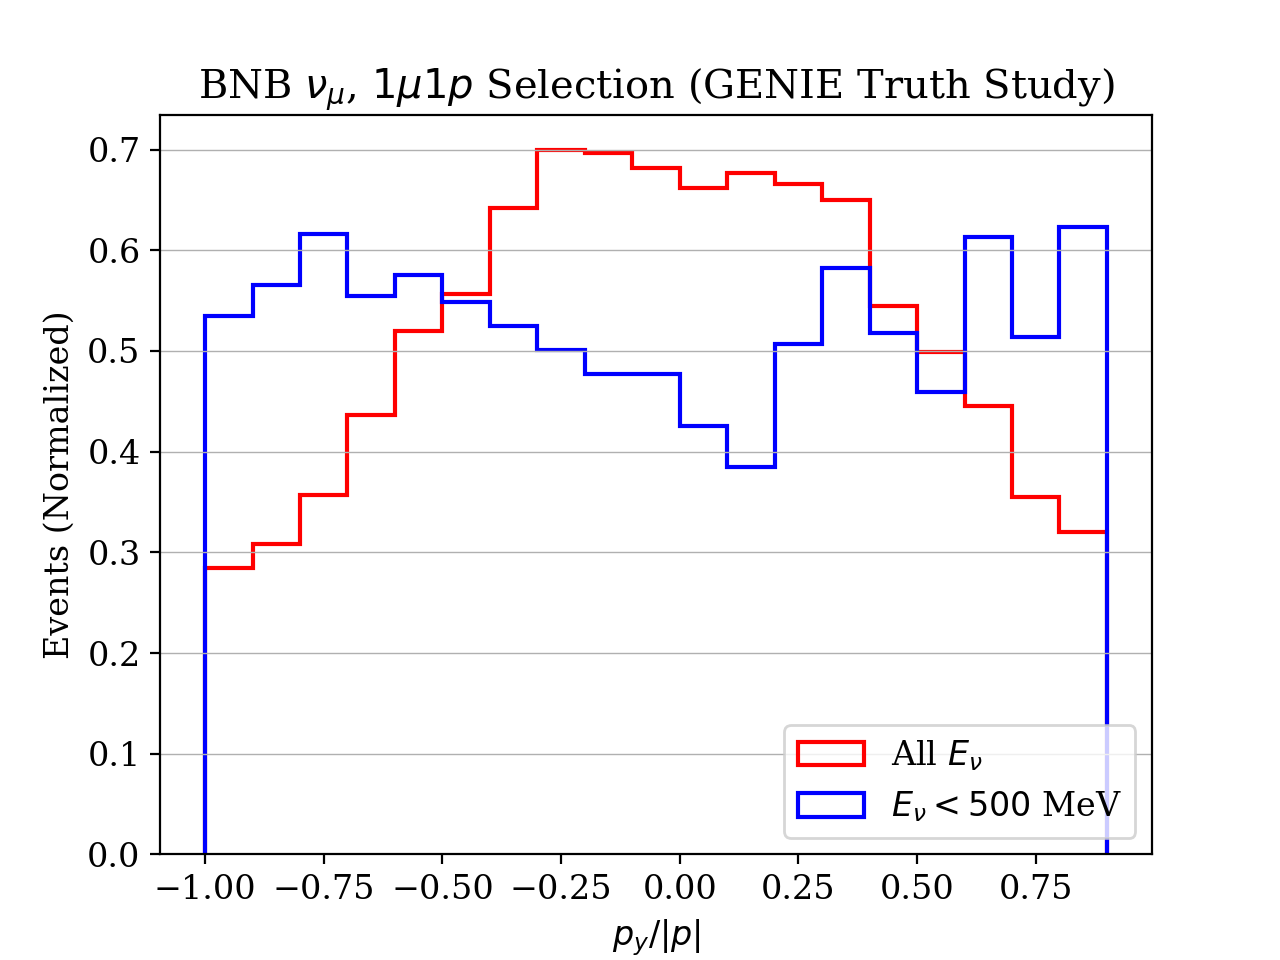

In [14]:
fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1mu1p["py_mu"]/df_1mu1p["p_mu"], color='red', label='All $E_\\nu$',bins=np.arange(-1.,1.,0.1), density=True, **pltops_hist)
plt.hist(df_1mu1p.query("e<0.5")["py_mu"]/df_1mu1p.query("e<0.5")["p_mu"], color='blue', label='$E_\\nu < 500$ MeV', bins=np.arange(-1.,1.,0.1), density=True, **pltops_hist)
plt.title("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
plt.xlabel("$p_y / |p|$")
plt.ylabel("Events (Normalized)")
plt.legend(loc=4)
plt.show()


In [15]:
p_df_1muNp = p_df_grouped.filter(lambda x: filter_1muNp_numba(x,thresh_mu=0.0,thresh_p=0.03,min_p_count=0,max_p_count=999))
p_df_1muNp_p1 = p_df_1muNp.query("pdgcode==2212").sort_values(by=["e"],ascending=False).groupby(["run","event","truth_index"],as_index=False).nth(0).sort_values(by=["event"])
p_df_1muNp_p2 = p_df_1muNp.query("pdgcode==2212").sort_values(by=["e"],ascending=False).groupby(["run","event","truth_index"],as_index=False).nth(1).sort_values(by=["event"])
p_df_1muNp_p3 = p_df_1muNp.query("pdgcode==2212").sort_values(by=["e"],ascending=False).groupby(["run","event","truth_index"],as_index=False).nth(2).sort_values(by=["event"])
p_df_1muNp_mu = p_df_1muNp.query("pdgcode==13").groupby(["run","event","truth_index"],as_index=False).first()
p_df_1muNp_nu = p_df_1muNp.query("pdgcode==14").groupby(["run","event","truth_index"],as_index=False).first()

In [16]:
@numba.jit(nopython=True)
def count_Np(energy,mass,status,pdgcode,
             thresh_p=0.03):
    return ((status==1)&(pdgcode==2212)&((energy-mass)>=thresh_p)).sum()

In [17]:
p_df_1muNp_np = p_df_1muNp.groupby(["run","event","truth_index"],as_index=False).apply(lambda x: count_Np(x["e"].values,x["mass"].values,x["status"].values,x["pdgcode"].values,thresh_p=0.03)).reset_index(name='n_p')

In [18]:
df_1muNp = t_df.copy()
df_1muNp = df_1muNp.merge(p_df_1muNp_nu,on=["run","event","truth_index"],suffixes=["","_nu"])
df_1muNp = df_1muNp.merge(p_df_1muNp_mu,on=["run","event","truth_index"],suffixes=["","_mu"])
df_1muNp = df_1muNp.merge(p_df_1muNp_p1,how='left',on=["run","event","truth_index"],suffixes=["","_p1"])
df_1muNp = df_1muNp.merge(p_df_1muNp_p2,how='left',on=["run","event","truth_index"],suffixes=["","_p2"])
df_1muNp = df_1muNp.merge(p_df_1muNp_p3,how='left',on=["run","event","truth_index"],suffixes=["","_p3"])
df_1muNp = df_1muNp.merge(p_df_1muNp_np,how='left',on=["run","event","truth_index"])

<IPython.core.display.Javascript object>


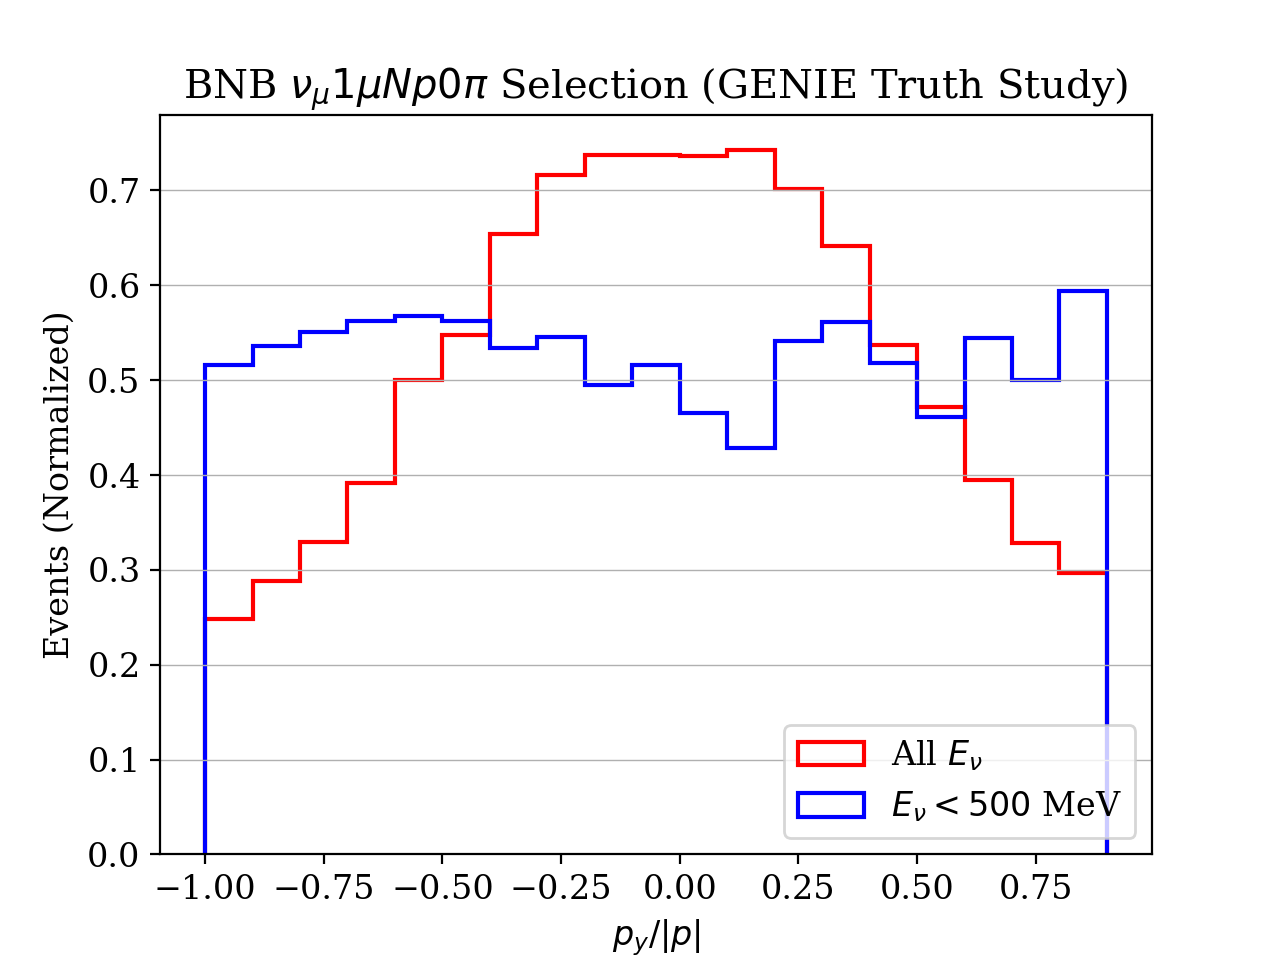

In [19]:
fig,ax = plt.subplots()

bins_py_ratio=np.arange(-1.,1.,0.1)

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1muNp["py_mu"]/df_1muNp["p_mu"], color='red', label='All $E_\\nu$',bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("e<0.5")["py_mu"]/df_1muNp.query("e<0.5")["p_mu"], color='blue', label='$E_\\nu < 500$ MeV', bins=bins_py_ratio, density=True, **pltops_hist)
plt.title("BNB $\\nu_\mu 1\mu Np 0\pi$ Selection (GENIE Truth Study)")
plt.xlabel("$p_y / |p|$")
plt.ylabel("Events (Normalized)")
plt.legend(loc=4)
plt.show()


<IPython.core.display.Javascript object>


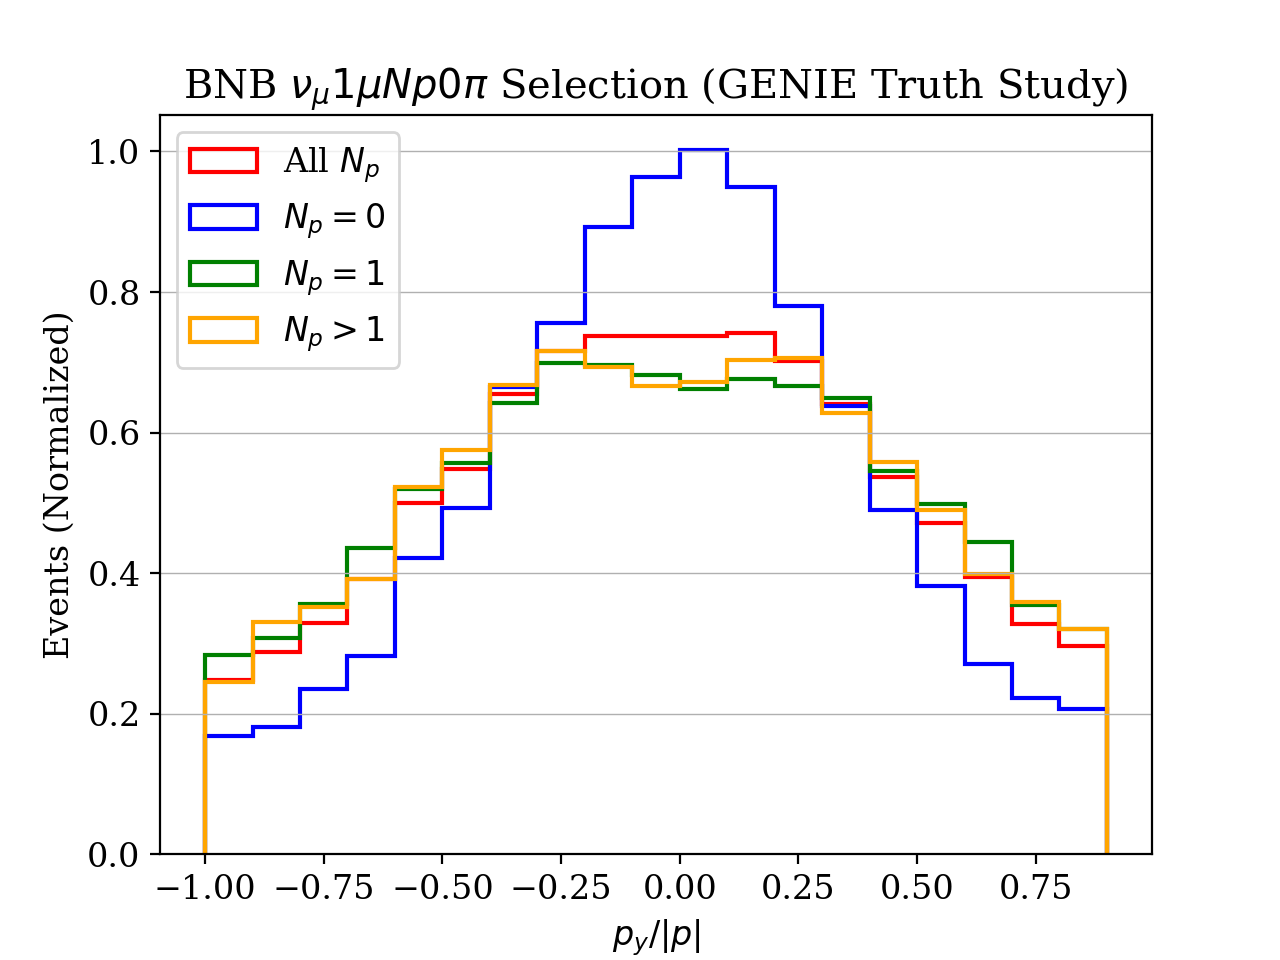

In [20]:
fig,ax = plt.subplots()

bins_py_ratio=np.arange(-1.,1.,0.1)

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1muNp["py_mu"]/df_1muNp["p_mu"], color='red', label='All $N_p$',bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p==0")["py_mu"]/df_1muNp.query("n_p==0")["p_mu"], color='blue', label='$N_p=0$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p==1")["py_mu"]/df_1muNp.query("n_p==1")["p_mu"], color='green', label='$N_p=1$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p>1")["py_mu"]/df_1muNp.query("n_p>1")["p_mu"], color='orange', label='$N_p>1$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.title("BNB $\\nu_\mu 1\mu Np 0\pi$ Selection (GENIE Truth Study)")
plt.xlabel("$p_y / |p|$")
plt.ylabel("Events (Normalized)")
plt.legend(loc=2)
plt.show()


<IPython.core.display.Javascript object>


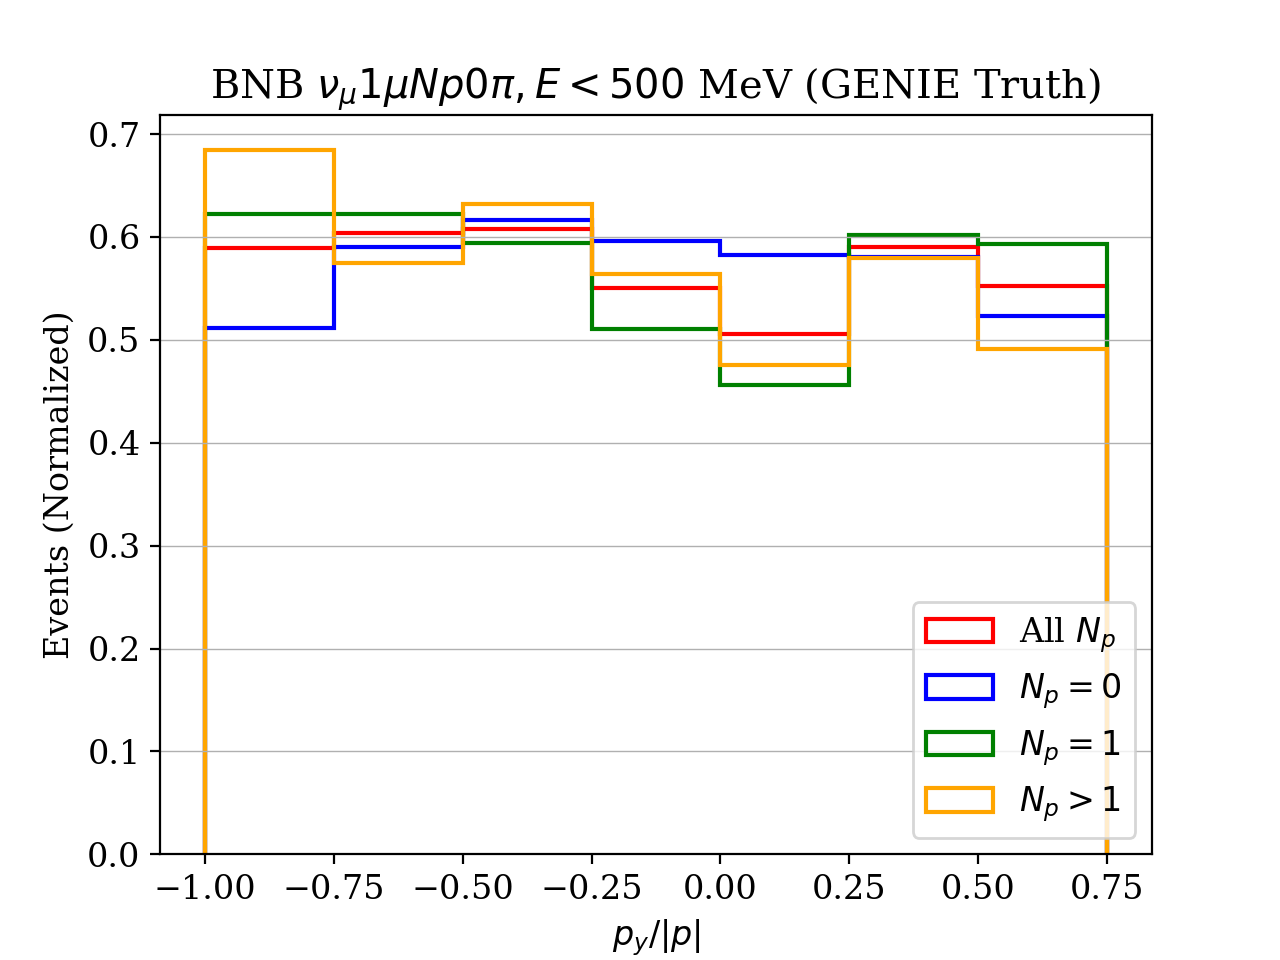

In [21]:
fig,ax = plt.subplots()

bins_py_ratio=np.arange(-1.,1.,0.25)

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1muNp.query("e<0.5")["py_mu"]/df_1muNp.query("e<0.5")["p_mu"], color='red', label='All $N_p$',bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p==0 and e<0.5")["py_mu"]/df_1muNp.query("n_p==0 and e<0.5")["p_mu"], color='blue', label='$N_p=0$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p==1 and e<0.5")["py_mu"]/df_1muNp.query("n_p==1 and e<0.5")["p_mu"], color='green', label='$N_p=1$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p>1 and e<0.5")["py_mu"]/df_1muNp.query("n_p>1 and e<0.5")["p_mu"], color='orange', label='$N_p>1$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.title("BNB $\\nu_\mu 1\mu Np 0\pi, E<500$ MeV (GENIE Truth)")
plt.xlabel("$p_y / |p|$")
plt.ylabel("Events (Normalized)")
plt.legend(loc=4)
plt.show()


<IPython.core.display.Javascript object>


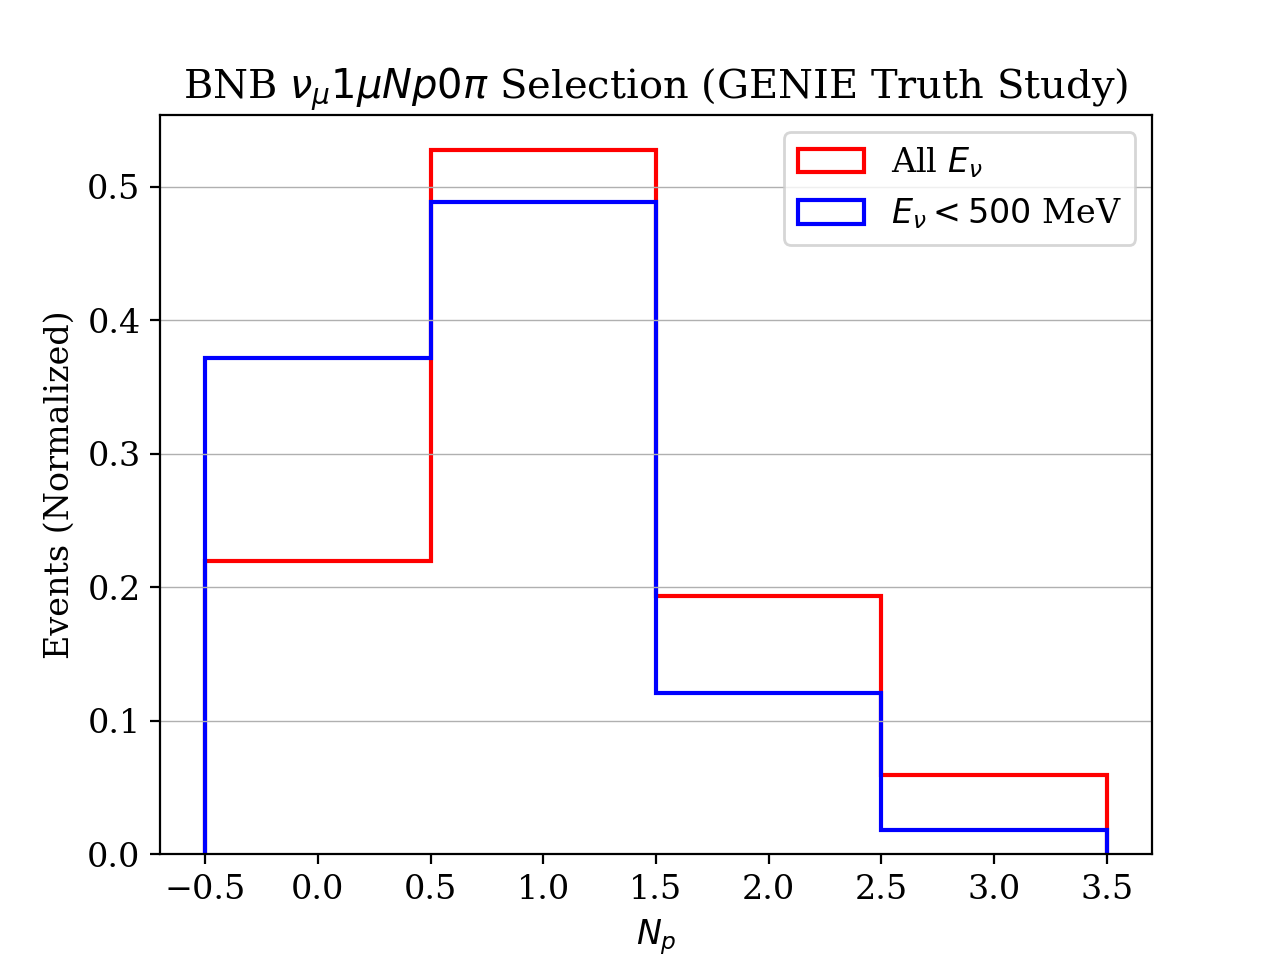

In [22]:
fig,ax = plt.subplots()

bins_np=np.arange(-0.5,4.5,1.0)

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1muNp["n_p"], color='red', label='All $E_\\nu$',bins=bins_np, density=True, **pltops_hist)
plt.hist(df_1muNp.query("e<0.5")["n_p"], color='blue', label='$E_\\nu < 500$ MeV', bins=bins_np, density=True, **pltops_hist)
plt.title("BNB $\\nu_\mu 1\mu Np 0\pi$ Selection (GENIE Truth Study)")
plt.xlabel("$N_p$")
plt.ylabel("Events (Normalized)")
plt.legend(loc=1)
plt.show()
